In [1]:
import argparse
import numpy as np
from PIL import Image

%matplotlib notebook
import matplotlib.pyplot as plt

Image.MAX_IMAGE_PIXELS = 11135877120


In [2]:
imageFile='../image2.tif'
saveFile='image2'
#Io=240
Io = 255
alpha=1
beta=0.15

img = np.array(Image.open(imageFile))
    

In [3]:
# Haematoxylin, Red, DAB reference (where Red is Alkaline Phosphatase) - OD matrix
HRDref = np.array([[0.651, 0.185, 0.269],
                   [0.701, 0.78, 0.568],
                   [0.29, 0.598, 0.778]])
    

        
maxCRef = np.array([0.7, 1.0308, 0.5])
    
# define height and width of image
h, w, c = img.shape
    


In [4]:
img[1,1:10,:]

array([[205, 191, 182],
       [205, 191, 182],
       [201, 191, 179],
       [207, 195, 183],
       [210, 197, 188],
       [212, 198, 189],
       [210, 196, 187],
       [210, 193, 185],
       [209, 192, 185]], dtype=uint8)

In [5]:
# reshape image
img = img.reshape((-1,3))


In [6]:
img[:,1].size

6071184

<IPython.core.display.Javascript object>


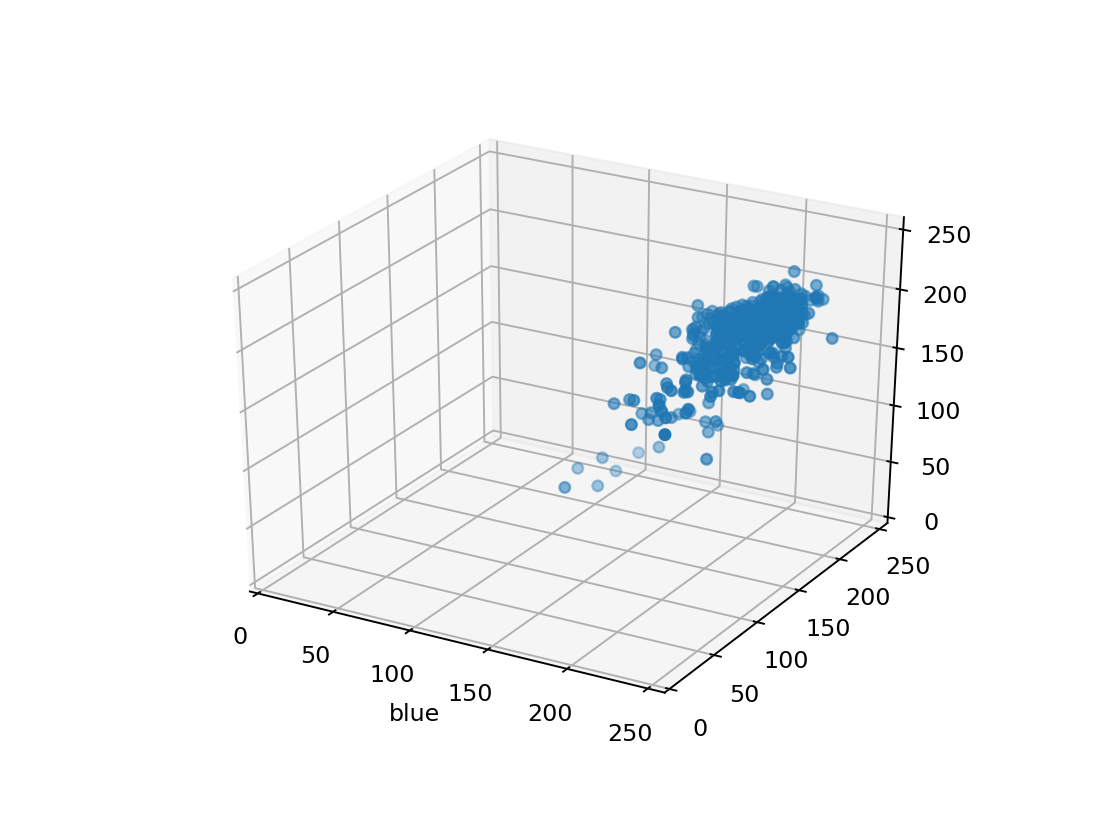

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(img[1:6000000:10000,0], img[1:6000000:10000,1], img[1:6000000:10000,2], zdir='z', s=20, c=None, depthshade=True)

ax.set(xlim=(0, 255), ylim=(0,255), zlim=(0,255))

ax.set_xlabel("red")
ax.set_ylabel("green")
ax.set_zlabel("blue")

plt.show()


In [8]:
# calculate optical density
OD = -np.log((img.astype(np.float)+1)/Io)

beta = 0.15

# remove transparent pixels
ODhat = OD[~np.any(OD<beta, axis=1)]

# compute eigenvectors
covariance = np.cov(ODhat.T)
eigvals, eigvecs = np.linalg.eigh(covariance)

#eigvecs *= -1
print("EIGENVALS = " + str(eigvals))

print("DYE VECTORS 0 = " + str(eigvecs[:, 0]))
print("DYE VECTORS 1 = " + str(eigvecs[:, 1]))
print("DYE VECTORS 2 = " + str(eigvecs[:, 2]))


EIGENVALS = [0.00236531 0.00321728 0.03852066]
DYE VECTORS 0 = [-0.65843135  0.64545206 -0.38711729]
DYE VECTORS 1 = [ 0.70478648  0.34828089 -0.61804242]
DYE VECTORS 2 = [-0.2640912  -0.67977354 -0.68422494]


<IPython.core.display.Javascript object>


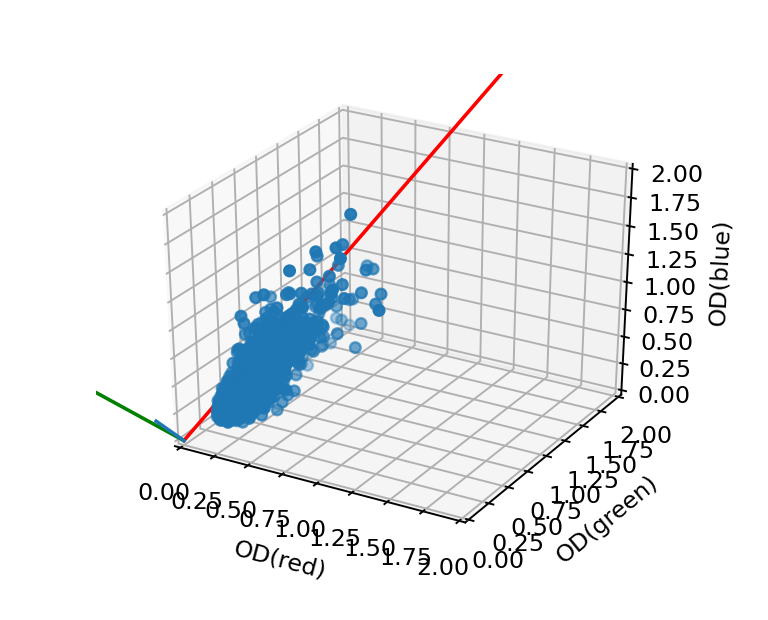

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(ODhat[1:6000000:1000,0], ODhat[1:6000000:1000,1], ODhat[1:6000000:1000,2], zdir='z', s=20, c=None, depthshade=True)

ax.set(xlim=(0.0, 2.0), ylim=(0.0, 2.0), zlim=(0.0, 2.0))

ax.set_xlabel("OD(red)")
ax.set_ylabel("OD(green)")
ax.set_zlabel("OD(blue)")

ax.plot([0.0, -eigvecs[0,2]*4], [0.0, -eigvecs[1,2]*4],[0.0, -eigvecs[2,2]*4],'r-')

ax.plot([0.0, -eigvecs[0,1]*2], [0.0, -eigvecs[1,1]*2],[0.0, -eigvecs[2,1]*2],'g-')

ax.plot([0.0, eigvecs[0,0]], [0.0, eigvecs[1,0]],[0.0, eigvecs[2,0]])


plt.show()

In [10]:
#project on the plane spanned by the eigenvectors corresponding to the two 
# largest eigenvalues    
That = ODhat.dot(eigvecs[:,1:3])

phi = np.arctan2(That[:,1],That[:,0])

minPhi = np.percentile(phi, alpha)
maxPhi = np.percentile(phi, 100-alpha)


In [11]:
minPhi/(2*np.pi)*360.0, maxPhi/(2*np.pi)*360.0

(-95.82197815554596, -68.17949417298662)

In [12]:
vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)


In [13]:
vMin, vMax

(array([[0.19123691],
        [0.64093829],
        [0.74338856]]),
 array([[0.50713904],
        [0.76052575],
        [0.40547574]]))

In [14]:
# a heuristic to make the vector corresponding to hematoxylin first and the 
# one corresponding to red second
if vMin[0] > vMax[0]:
    HRD = np.array((vMin[:,0], vMax[:,0], eigvecs[:, 0])).T
else:
    HRD = np.array((vMax[:,0], vMin[:,0], eigvecs[:, 0])).T


In [15]:
# rows correspond to channels (RGB), columns to OD values
Y = np.reshape(OD, (-1, 3)).T

# determine concentrations of the individual stains
C = np.linalg.lstsq(HRD,Y, rcond=None)[0]


In [16]:
C

array([[ 0.16868321,  0.17544101,  0.17362812, ...,  0.08539181,
         0.19522206,  0.19522206],
       [ 0.30314195,  0.32357723,  0.33266621, ...,  0.34372466,
         0.26852673,  0.26852673],
       [-0.08415687, -0.08030081, -0.0790573 , ..., -0.06553979,
        -0.08105403, -0.08105403]])

In [17]:
# normalize stain concentrations
maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99), np.percentile(C[2,:], 99)])
tmp = np.divide(maxC,maxCRef)
C2 = np.divide(C,tmp[:, np.newaxis])


In [18]:
# recreate the image using reference mixing matrix
Inorm = np.multiply(Io, np.exp(-HRDref.dot(C2)))
Inorm[Inorm>255] = 254
Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  

# unmix hematoxylin and eosin
H = np.multiply(Io, np.exp(np.expand_dims(-HRDref[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
H[H>255] = 254
H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

R = np.multiply(Io, np.exp(np.expand_dims(-HRDref[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
R[R>255] = 254
R = np.reshape(R.T, (h, w, 3)).astype(np.uint8)

D = np.multiply(Io, np.exp(np.expand_dims(-HRDref[:,2], axis=1).dot(np.expand_dims(C2[2,:], axis=0))))
D[D>255] = 254
D = np.reshape(D.T, (h, w, 3)).astype(np.uint8)


In [19]:
if saveFile is not None:
    Image.fromarray(Inorm).save(saveFile+'.png')
    Image.fromarray(H).save(saveFile+'_H.png')
    Image.fromarray(R).save(saveFile+'_R.png')
    Image.fromarray(D).save(saveFile+'_D.png')
